Detecção de SPAM com LSTM e Vetorização GloVe
===

Neste notebook, foi desenvolvido um modelo para a detecção de SPAM utilizando um dataset contendo mensagens classificadas como "SPAM" ou "HAM" (não-SPAM). O modelo principal foi baseado em LSTM (Long Short-Term Memory) com vetorização de palavras usando o GloVe (Global Vectors for Word Representation). Também foi explorada uma abordagem alternativa com o modelo Random Forest, utilizando embeddings gerados pelo modelo Sentence-BERT (MiniLM-L6), para comparar os resultados.

## Carregamento dos Dados

O dataset de SPAM foi carregado a partir de um arquivo CSV, contendo as colunas "Category" (indicando se a mensagem é SPAM ou HAM) e "Message" (o texto da mensagem).

> Overview:
This dataset contains a collection of emails, categorized into two classes: "Spam" and "Non-Spam" (often referred to as "Ham"). These emails have been carefully curated and labeled to aid in the development of spam email detection models. Whether you are interested in email filtering, natural language processing, or machine learning, this dataset can serve as a valuable resource for training and evaluation.
>
> Context:
Spam emails continue to be a significant issue, with malicious actors attempting to deceive users with unsolicited, fraudulent, or harmful messages. This dataset is designed to facilitate research, development, and testing of algorithms and models aimed at accurately identifying and filtering spam emails, helping protect users from various threats.
>
> Content:
The dataset includes the following features:
Message: The content of the email, including the subject line and message body.
Category: Categorizes each email as either "Spam" or "Ham" (Non-Spam).
>
> License:
Please note that this dataset is for research and analysis purposes only and may be subject to copyright and data use restrictions. Ensure compliance with relevant policies when using this data.
>
> Author: Abdallah Wagih Ibrahim

In [7]:
!kaggle datasets download abdallahwagih/spam-emails

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/spam-emails
License(s): apache-2.0


In [8]:
!unzip spam-emails.zip

Archive:  spam-emails.zip
  inflating: spam.csv                


In [9]:
import pandas as pd
from typing import defaultdict
import re
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [10]:
df = pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Pré-processamento e Criação do Dataset

Foi realizado o pré-processamento das mensagens, incluindo a remoção de pontuações, caracteres especiais e palavras de parada (stopwords). Esse processo foi realizado com a função `replacement`, que limpou o texto das mensagens, preparando-as para a próxima etapa de vetorização.

Após o pré-processamento, foi criada uma nova coluna "Processed Message", que contém as mensagens limpas e prontas para o uso no modelo.

In [11]:
PONCTUATION = ".,;:!?-\"'`"
SPECIAL_CHARACTERS = "()[]{}<>|&$@#"
STOP_WORDS = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
    "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
    "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
    "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
    "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
    "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain",
    "aren", "couldn", "didn", "doesn", "hadn", "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "shan", "shouldn",
    "wasn", "weren", "won", "wouldn"
]

def replacement(text):
    text = text.lower()
    for i in PONCTUATION + SPECIAL_CHARACTERS:
      text = text.replace(i, " ")
    for i in STOP_WORDS:
      text = re.sub(r'\b{}\b'.format(i), '', text)
    return text

processing_pipeline = replacement

Length of vocab: 8813
Top five most frequent words: [('u', 1196), ('call', 590), ('2', 507), ('ur', 391), ('get', 390)]
Top five least frequent words: [('087187272008', 1), ('now1', 1), ('pity', 1), ('suggestions', 1), ('bitching', 1)]


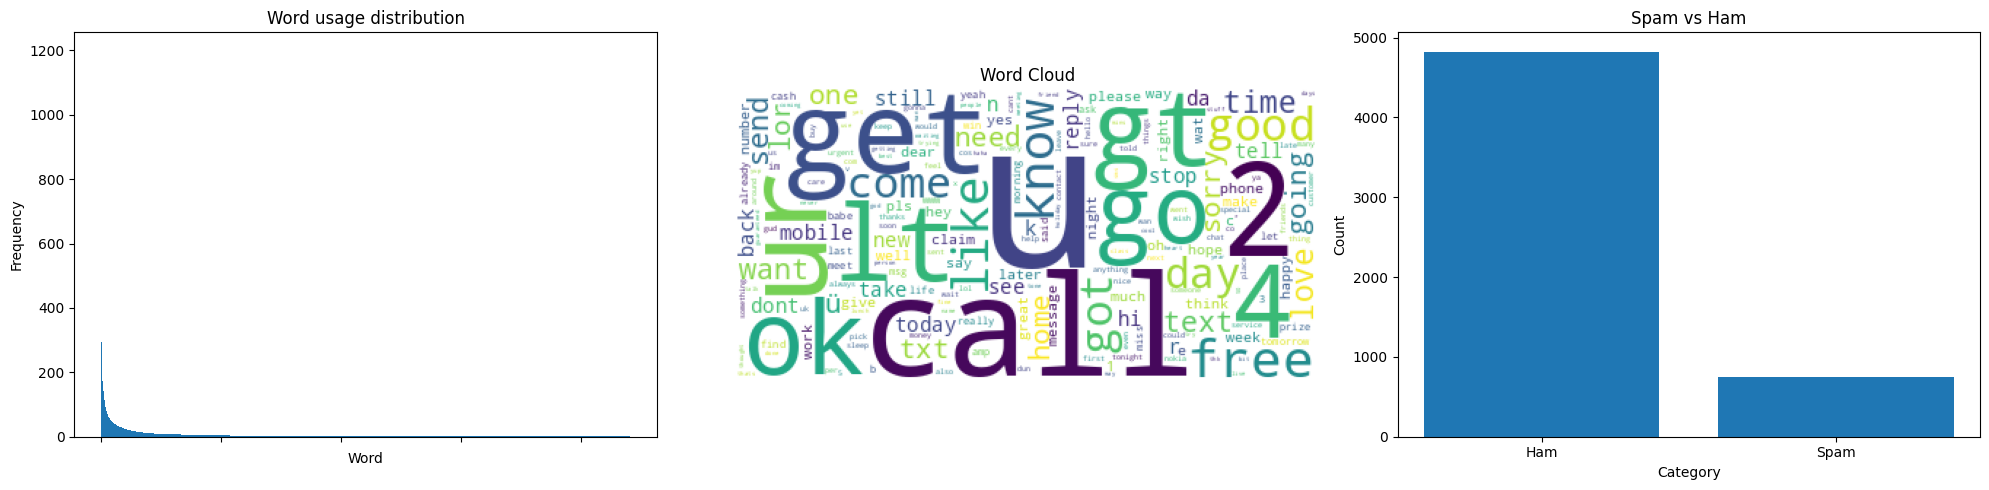

In [82]:
vocab = set()
frequency = defaultdict(int)

for i in df["Message"].apply(lambda i: replacement(i).split()):
  vocab.update(i)
  for i2 in i:
    frequency[i2] += 1

frequency = dict(sorted(frequency.items(), key=lambda i: i[1], reverse=True))

print(f"Length of vocab: {len(vocab)}")
print(f"Top five most frequent words: {list(frequency.items())[:5]}")
print(f"Top five least frequent words: {list(frequency.items())[-5:]}")

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].bar(range(len(frequency)), frequency.values(), width=3.)
axs[0].set_title("Word usage distribution")
axs[0].set_xlabel("Word")
axs[0].set_xticklabels([])
axs[0].set_ylabel("Frequency")

axs[1].imshow(WordCloud(background_color="white").generate_from_frequencies(frequency))
axs[1].axis("off")
axs[1].set_title("Word Cloud")

axs[2].bar(["Ham", "Spam"], df["Category"].value_counts())
axs[2].set_title("Spam vs Ham")
axs[2].set_xlabel("Category")
axs[2].set_ylabel("Count")

fig.tight_layout()
plt.show()

del fig, axs, vocab, frequency

In [13]:
df["Category"] = df["Category"].apply(lambda i: 0 if i == "ham" else 1)
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df["Processed Message"] = df["Message"].apply(processing_pipeline)
df.head()

,Category,Message,Processed Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkt...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


## Embedding com GloVe

A vetorização das mensagens foi realizada utilizando o modelo GloVe. Cada palavra das mensagens foi representada como um vetor de 300 dimensões. A média dos vetores das palavras presentes nas mensagens foi calculada para obter um único vetor representando cada mensagem.

In [15]:
import numpy as np

In [16]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2025-04-06 21:32:03--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-06 21:32:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 42s  

2025-04-06 21:34:47 (5.08 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [17]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
def create_glove_model():
    glove_model = {}
    with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

glove = create_glove_model()

In [19]:
def embed(text):
    words = text.split()
    embeddings = []
    for word in words:
        if word in glove:
            embeddings.append(glove[word])

    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)

In [20]:
df["Embedding"] = df["Processed Message"].apply(embed)
df.head()

,Category,Message,Processed Message,Embedding
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n ...,"[-0.065061636, 0.015510248, -0.1458716, 0.0001..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[0.060693905, -0.06634911, -0.113961674, -0.16..."
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkt...,"[-0.06743005, 0.11371115, 0.08698762, -0.11535..."
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say,"[-0.0125648845, -0.13505721, -0.107569665, -0...."
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though,"[-0.016699295, -0.026622768, 0.087139286, 0.11..."


## Treino da LSTM

Após a criação dos embeddings, o modelo LSTM foi construído e treinado para classificar as mensagens como SPAM ou HAM. A arquitetura do modelo consistiu de uma camada LSTM seguida de uma camada densa com ativação sigmoide.


O modelo foi treinado por 100 épocas, monitorando a perda durante o treinamento e a validação.

In [21]:
import keras
from sklearn.model_selection import train_test_split

In [48]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

model = keras.Sequential()
model.add(keras.layers.Input((1, df["Embedding"][0].shape[0])))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,777 (858.50 KB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
X, y = np.array(df["Embedding"].to_list()), np.array(df["Category"])
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4457, 1, 300)
Shape of y_train: (4457,)
Shape of X_test: (1115, 1, 300)
Shape of y_test: (1115,)


In [50]:
H = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8572 - loss: 0.3687 - val_accuracy: 0.9516 - val_loss: 0.1535
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9431 - loss: 0.1559 - val_accuracy: 0.9641 - val_loss: 0.1228
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9539 - loss: 0.1257 - val_accuracy: 0.9659 - val_loss: 0.1049
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9611 - loss: 0.1052 - val_accuracy: 0.9704 - val_loss: 0.0896
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9758 - loss: 0.0804 - val_accuracy: 0.9731 - val_loss: 0.0817
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9815 - loss: 0.0637 - val_accuracy: 0.9749 - val_loss: 0.0771
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9807 - loss: 0.0638 - val_accuracy: 0.9749 - val_loss: 0.0753
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9870 - loss: 0.0533 - val_accu

## Análise dos Resultados

A performance do modelo LSTM foi muito boa, com uma acurácia geral de **98%**. Ele apresentou uma excelente capacidade de identificar mensagens "ham" (não-SPAM), com precisão e recall próximos de **99%**. No entanto, o modelo teve um desempenho ligeiramente inferior ao identificar mensagens "spam", com precisão de **92%** e recall de **90%**.

Embora o modelo tenha obtido resultados sólidos, a menor performance na classe "spam" sugere que ainda há espaço para melhorias na identificação dessa classe minoritária. Isso pode ser devido ao desbalanceamento natural do conjunto de dados, onde há muitas mais mensagens "ham" do que "spam". No geral, o modelo se mostrou eficaz, mas ajustes podem ser feitos para melhorar a detecção de SPAM, como técnicas de balanceamento de classes ou otimização de parâmetros.

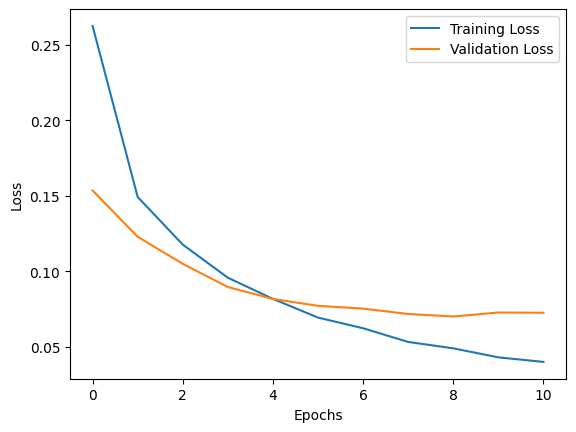

In [51]:
plt.plot(H.history["loss"], label="Training Loss")
plt.plot(H.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


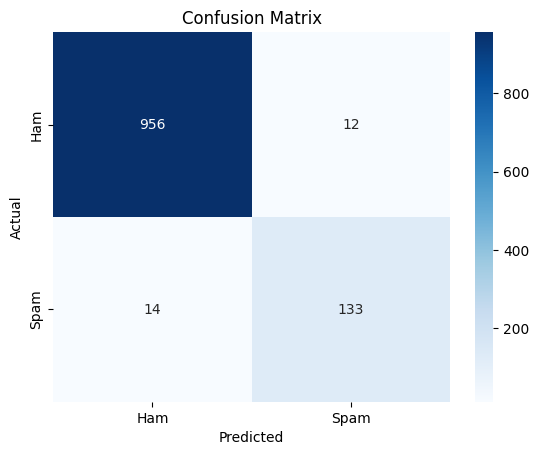

In [58]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)

labels = ["Ham", "Spam"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       968
           1       0.92      0.90      0.91       147

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



## Outra Perspectiva: RandomForestClassifier + SBERT

Como abordagem alternativa, foi utilizado o modelo Random Forest em conjunto com os embeddings gerados pelo modelo Sentence-BERT (MiniLM-L6), que também gerou representações vetoriais das mensagens. Essa abordagem foi treinada e a matriz de confusão foi gerada para comparar os resultados com o modelo LSTM.

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer

In [66]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [67]:
df["Embedding"] = df["Processed Message"].apply(lambda i: sbert.encode(i))
df.head()

,Category,Message,Processed Message,Embedding
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n ...,"[-0.052425224, -0.02143687, 0.068289734, -0.04..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[-0.03568897, -0.07348801, 0.03983084, -0.0556..."
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkt...,"[-0.02498941, 0.050593633, 0.012199415, -0.029..."
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say,"[-0.01678537, 0.04244423, 0.0050961142, -0.013..."
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though,"[0.031276923, -0.14296696, -0.017865691, -0.04..."


In [72]:
X, y = np.array(df["Embedding"].to_list()), np.array(df["Category"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4457, 384)
Shape of y_train: (4457,)
Shape of X_test: (1115, 384)
Shape of y_test: (1115,)


In [73]:
rfclf = RandomForestClassifier()
rfclf.fit(X_train, y_train)

RandomForestClassifier()

## Analise comparativa dos resultados

O modelo **SBERT + RandomForestClassifier** apresentou uma acurácia geral de **97%**, com uma **precisão de 98%** para a classe "spam". Isso significa que, quando o modelo classificou uma mensagem como SPAM, estava correto em 98% dos casos. No entanto, o **recall** para a classe "spam" foi de **79%**, o que indica que o modelo deixou passar uma quantidade considerável de mensagens SPAM (falsos negativos), falhando em identificar cerca de 21% das mensagens SPAM reais.

Comparando com o modelo **LSTM + GloVe**, que obteve uma acurácia geral de **98%** e um **recall de 90%** para a classe "spam", podemos ver que o **LSTM teve um desempenho superior em termos de recall**, identificando mais mensagens SPAM corretamente. Embora a **precisão** para SPAM tenha sido ligeiramente inferior no modelo LSTM (**92% contra 98%**), o **LSTM conseguiu detectar mais SPAM** sem classificar muitas mensagens "ham" como "spam".

Para o caso em questão, onde é preferível **minimizar os falsos positivos** e **maximizar os verdadeiros positivos** (ou seja, identificar SPAM corretamente sem classificar "ham" como SPAM), o modelo **LSTM + GloVe** seria mais indicado. Isso ocorre porque o **LSTM teve um recall mais alto**, capturando mais mensagens SPAM, o que é crucial para garantir que o modelo detecte corretamente as mensagens SPAM.

Por outro lado, o modelo **SBERT + RF** teve um desempenho muito bom na **precisão**, mas o recall mais baixo sugere que ele é mais conservador na classificação de SPAM, o que pode ser útil em cenários onde a precisão é mais crítica, mas no caso de detecção de SPAM, é importante priorizar o recall.

In [77]:
y_pred = rfclf.predict(X_test)

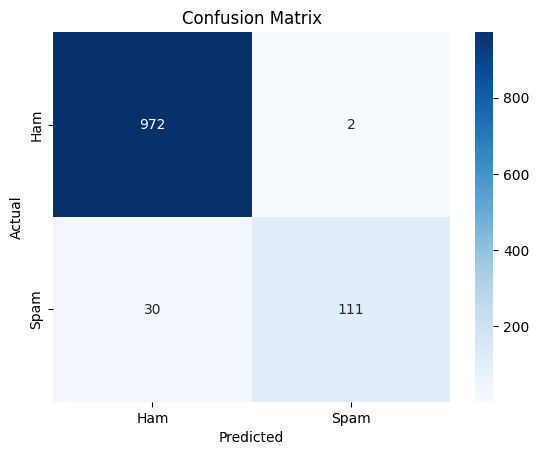

In [78]:
cm = confusion_matrix(y_test, y_pred)

labels = ["Ham", "Spam"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       974
           1       0.98      0.79      0.87       141

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

